### Step 1: Dataset Summary, Data Types, and Nulls Overview

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, expr
from pyspark.sql.types import NumericType

In [ ]:
spark = SparkSession.builder \
    .appName("Read Parquet Example") \
    .config("spark.hadoop.hadoop.security.authentication", "simple") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()

In [ ]:
df = spark.read.parquet("../data/adr_flattened_2025.parquet")

#### **Step 1A: Show Schema**

This helps you understand the column names and their data types.

In [ ]:
df.printSchema()

root
 |-- safetyreportid: long (nullable = true)
 |-- age: double (nullable = true)
 |-- age_unit: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- country: string (nullable = true)
 |-- reaction: string (nullable = true)
 |-- reaction_outcome: double (nullable = true)
 |-- drug: string (nullable = true)
 |-- drug_indication: string (nullable = true)
 |-- startdate: double (nullable = true)
 |-- enddate: double (nullable = true)



#### **Step 1B: Sample Rows**

Take a peek at the actual data.

In [5]:
df.show(5, truncate=False)

+--------------+----+--------+---+-------+--------+----------------+------------+-------------------+-----------+-------+
|safetyreportid|age |age_unit|sex|country|reaction|reaction_outcome|drug        |drug_indication    |startdate  |enddate|
+--------------+----+--------+---+-------+--------+----------------+------------+-------------------+-----------+-------+
|24887643      |77.0|801.0   |2.0|US     |Delirium|1.0             |NUPLAZID    |Parkinson^s disease|2.0240624E7|NULL   |
|24887643      |77.0|801.0   |2.0|US     |Delirium|1.0             |ASPIRIN     |NULL               |NULL       |NULL   |
|24887643      |77.0|801.0   |2.0|US     |Delirium|1.0             |ATORVASTATIN|NULL               |NULL       |NULL   |
|24887643      |77.0|801.0   |2.0|US     |Delirium|1.0             |BACLOFEN    |NULL               |NULL       |NULL   |
|24887643      |77.0|801.0   |2.0|US     |Delirium|1.0             |BUDESONIDE  |NULL               |NULL       |NULL   |
+--------------+----+---

####  **Step 1C: Count Total Rows**

In [6]:
print(f"Total rows: {df.count()}")

Total rows: 29286626


#### **Step 1D: Missing/Null Values Summary**

In [7]:
columns_to_exclude = ['startdate', 'enddate']  # exclude these for now
safe_columns = [c for c in df.columns if c not in columns_to_exclude]
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

In [8]:
null_counts = df.select([
    count(when(col(c).isNull() | (isnan(col(c)) if c in numeric_cols else False), c)).alias(c)
    for c in safe_columns
])

null_counts.show(truncate=False)

+--------------+-------+--------+-------+-------+--------+----------------+----+---------------+
|safetyreportid|age    |age_unit|sex    |country|reaction|reaction_outcome|drug|drug_indication|
+--------------+-------+--------+-------+-------+--------+----------------+----+---------------+
|0             |6914617|6914326 |4842284|310921 |0       |135516          |0   |15861577       |
+--------------+-------+--------+-------+-------+--------+----------------+----+---------------+



### Summary of What We Know

| Column                 | Missing Values | Notes                                          |
| ---------------------- | -------------- | ---------------------------------------------- |
| `age`, `age_unit`      | \~6.9 million  | 23% missing — may need imputation              |
| `sex`                  | \~4.8 million  | Can impact demographic analysis                |
| `country`              | \~0.3 million  | Mostly present                                 |
| `reaction`             | 0              | ✅ fully populated                              |
| `reaction_outcome`     | \~135k         | Mostly populated                               |
| `drug`                 | 0              | ✅ fully populated                              |
| `drug_indication`      | \~15.8 million | ⚠️ \~54% missing — consider NLP for enrichment |
| `startdate`, `enddate` | excluded       | Needs fixing due to timestamp format issues    |

### Step 2: Univariate Analysis (What values are present?)

#### 2A: Distribution of `sex`

In [9]:
df.groupBy("sex").count().orderBy("count", ascending=False).show()

+----+--------+
| sex|   count|
+----+--------+
| 2.0|19808825|
|NULL| 4842284|
| 1.0| 4635517|
+----+--------+



#### 2B: Distribution of `reaction` (Top 20)

In [10]:
df.groupBy("reaction").count().orderBy("count", ascending=False).show(20, truncate=False)

+------------------------------------+------+
|reaction                            |count |
+------------------------------------+------+
|Off label use                       |493594|
|Fatigue                             |328184|
|Drug ineffective                    |307326|
|Headache                            |280754|
|Pain                                |273370|
|Nausea                              |272730|
|Condition aggravated                |250431|
|Diarrhoea                           |225139|
|Dyspnoea                            |222455|
|Rash                                |218310|
|Arthralgia                          |216461|
|Vomiting                            |209909|
|Malaise                             |193865|
|Pyrexia                             |189830|
|Pneumonia                           |186624|
|Intentional product use issue       |176494|
|Hypertension                        |176242|
|Product use in unapproved indication|175690|
|Pain in extremity                

#### 2C: Distribution of `drug` (Top 20)

In [11]:
df.groupBy("drug").count().orderBy("count", ascending=False).show(20, truncate=False)

+--------------------------+------+
|drug                      |count |
+--------------------------+------+
|METHOTREXATE              |835466|
|ACTEMRA                   |824772|
|PREDNISONE                |725348|
|SULFASALAZINE             |696101|
|INFLECTRA                 |557646|
|RITUXIMAB                 |556850|
|FOLIC ACID                |481157|
|ORENCIA                   |379130|
|CETIRIZINE HYDROCHLORIDE  |377850|
|DESOXIMETASONE            |366335|
|LEFLUNOMIDE               |322141|
|HYDROXYCHLOROQUINE        |307802|
|ENBREL                    |299198|
|ACETAMINOPHEN             |296279|
|XELJANZ                   |277736|
|PHTHALYLSULFATHIAZOLE     |274797|
|HYDROXYCHLOROQUINE SULFATE|265096|
|REMICADE                  |251051|
|INFLIXIMAB                |246192|
|HUMIRA                    |240388|
+--------------------------+------+
only showing top 20 rows


#### 2D: Distribution of `country`

In [12]:
df.groupBy("country").count().orderBy("count", ascending=False).show(20, truncate=False)

+-------+--------+
|country|count   |
+-------+--------+
|CA     |21092209|
|US     |4524667 |
|GB     |589988  |
|DE     |536700  |
|NULL   |310921  |
|JP     |290947  |
|FR     |275826  |
|CN     |172602  |
|PL     |168603  |
|AT     |164882  |
|PT     |111927  |
|BR     |106999  |
|ES     |95582   |
|CO     |94114   |
|IT     |86292   |
|AU     |85035   |
|IN     |77275   |
|CH     |49300   |
|MX     |38390   |
|IE     |33628   |
+-------+--------+
only showing top 20 rows


#### 2E: Distribution of `reaction_outcome`

In [13]:
df.groupBy("reaction_outcome").count().orderBy("count", ascending=False).show()

+----------------+--------+
|reaction_outcome|   count|
+----------------+--------+
|             5.0|12891444|
|             6.0| 7636419|
|             3.0| 5799012|
|             1.0| 2013425|
|             2.0|  758002|
|            NULL|  135516|
|             4.0|   52808|
+----------------+--------+



## Step 2 Summary: Insights from Categorical Columns

### 🔹 1. `sex` Distribution

```plaintext
2.0 → 19.8M (Likely Female)
1.0 → 4.6M (Likely Male)
NULL → 4.8M (missing ~16%)
```

🔸**Action**: Consider mapping:

* `1.0` → Male
* `2.0` → Female
* `NULL` → "Unknown" or impute

---

### 🔹 2. Top 20 `reaction`s

* Common adverse reactions include: **Fatigue**, **Nausea**, **Headache**, **Pain**, **Rash**, **Vomiting**, etc.
* **“Off label use”** and **“Drug ineffective”** also rank high.

🔸**Action**: These categories are highly frequent and would form **output labels** if you do:

* **Multi-class classification** (predict most likely reaction)
* **Multi-label classification** (if a drug can have multiple reactions)

---

### 🔹 3. Top 20 `drug`s

* Common drugs include **METHOTREXATE**, **ACTEMRA**, **PREDNISONE**, etc.
* Mostly drugs used for autoimmune conditions, cancer, inflammation.

🔸**Action**: Feature engineering on drugs needed:

* You may **map drugs to drug classes** using external resources (e.g., ATC code)
* Or embed drugs via frequency or TF-IDF if modeling.

### Step 3: Bivariate analysis

#### A. Top reactions per drug

In [14]:
df.groupBy("drug", "reaction").count().orderBy("count", ascending=False).show(20, truncate=False)

+-------------+------------------------------------------------+-----+
|drug         |reaction                                        |count|
+-------------+------------------------------------------------+-----+
|INFLECTRA    |Off label use                                   |53910|
|INFLECTRA    |Condition aggravated                            |30660|
|INFLECTRA    |Intentional product use issue                   |19754|
|INFLECTRA    |Arthralgia                                      |17521|
|INFLECTRA    |Inappropriate schedule of product administration|14570|
|VEDOLIZUMAB  |Off label use                                   |11760|
|PREDNISONE   |Off label use                                   |11288|
|METHOTREXATE |Off label use                                   |10746|
|ACTEMRA      |Off label use                                   |9173 |
|RITUXIMAB    |Off label use                                   |8694 |
|ACTEMRA      |Pain                                            |8598 |
|ACTEM

####  B. Reactions by `sex`

In [15]:
df.groupBy("sex", "reaction").count().orderBy("count", ascending=False).show(20, truncate=False)

+----+-------------------------+------+
|sex |reaction                 |count |
+----+-------------------------+------+
|2.0 |Off label use            |263054|
|2.0 |Fatigue                  |213636|
|2.0 |Headache                 |204137|
|2.0 |Pain                     |195985|
|2.0 |Nausea                   |193333|
|2.0 |Drug ineffective         |189258|
|2.0 |Diarrhoea                |157701|
|2.0 |Rash                     |155877|
|2.0 |Vomiting                 |154135|
|2.0 |Arthralgia               |150346|
|2.0 |Malaise                  |146547|
|2.0 |Dyspnoea                 |142110|
|2.0 |Rheumatoid arthritis     |137005|
|NULL|Off label use            |133102|
|2.0 |Hypersensitivity         |132989|
|2.0 |Joint swelling           |132756|
|2.0 |Infusion related reaction|132242|
|2.0 |Hypertension             |131575|
|2.0 |Pneumonia                |130201|
|2.0 |Condition aggravated     |129512|
+----+-------------------------+------+
only showing top 20 rows


#### C. Average age per reaction

In [17]:
from pyspark.sql.functions import avg

df.groupBy("reaction").agg(avg("age").alias("avg_age")).orderBy("avg_age", ascending=False).show(20)

+--------------------+------------------+
|            reaction|           avg_age|
+--------------------+------------------+
|Spinal subdural h...|             831.0|
|Varicose vein ope...|             751.0|
|   Diabetic glaucoma| 456.3333333333333|
|Wrong product pro...|             215.4|
|Central nervous s...|168.14285714285714|
|Diabetic hypergly...|159.33333333333334|
|Anaemia of pregnancy|123.84210526315789|
|  Hypoglycaemic coma|121.68823529411765|
|Coronary arterial...|111.55023923444976|
|Cerebrovascular i...|              98.0|
|Diabetic complica...|            96.275|
|Sphingomonas pauc...|              95.0|
|Superinfection fu...|              95.0|
|Acquired mixed hy...|              95.0|
|Peripheral exudat...|              94.0|
|Antigliadin antib...|              94.0|
|Blood culture neg...|              94.0|
|  Adrenal thrombosis|              94.0|
|Acquired corneal ...|              94.0|
|Electrophoresis p...|              93.0|
+--------------------+------------

### **Summary of EDA Insights**

#### 🔹 **Most Common Drugs**

* **INFLECTRA**, **ACTEMRA**, **PREDNISONE**, and **METHOTREXATE** top the chart.
* These are primarily **immunosuppressants / anti-inflammatory drugs**.

#### 🔹 **Frequent Reactions**

* **Off label use**, **Fatigue**, **Drug ineffective**, **Pain**, **Nausea**, **Rash**, etc.

#### 🔹 **Reactions by Drug**

* INFLECTRA: Off-label use, Condition aggravated, Arthralgia
* ACTEMRA: Pain, Weight gain, Joint swelling

#### 🔹 **Sex-based Reactions**

* Majority of reports come from **females (2.0)**.
* Most common female-linked ADRs: **Fatigue, Nausea, Rash, Headache, Vomiting**

#### 🔹 **Average Age by Reaction**

* Some reactions like **Spinal subdural hematoma** and **Diabetic glaucoma** occur at very high avg ages.
* But many others are in typical senior ranges (\~60–80 years).

#### Step 1: Top 20 Reactions

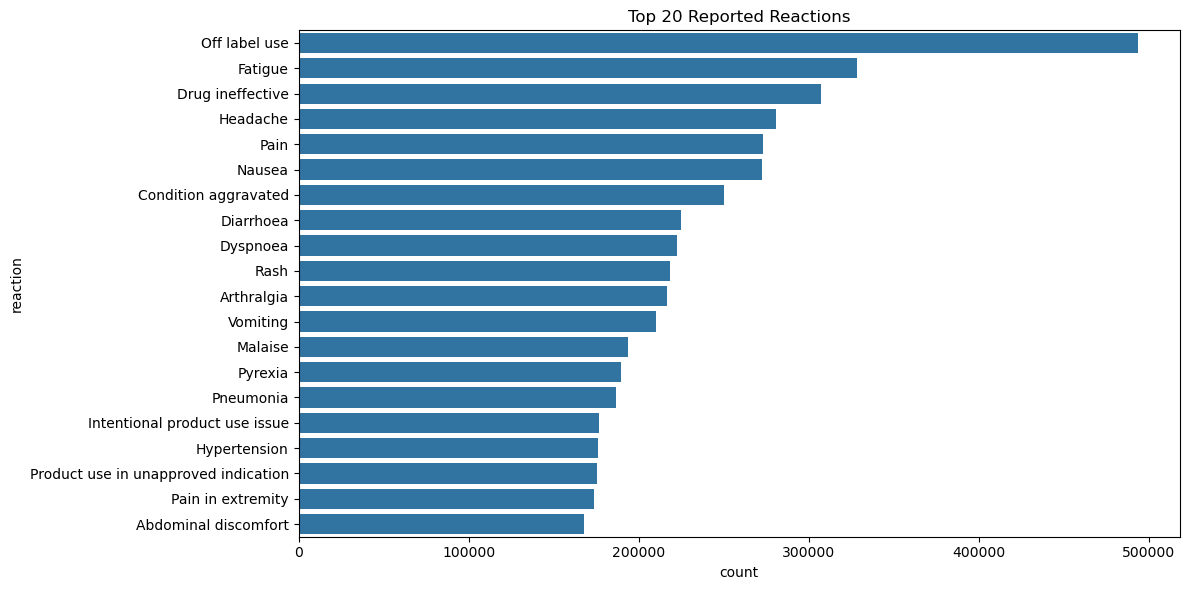

In [21]:
top_reactions = df.groupBy("reaction").count().orderBy("count", ascending=False).limit(20).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=top_reactions, x="count", y="reaction")
plt.title("Top 20 Reported Reactions")
plt.tight_layout()
plt.show()

#### Step 2: Top 20 Drugs

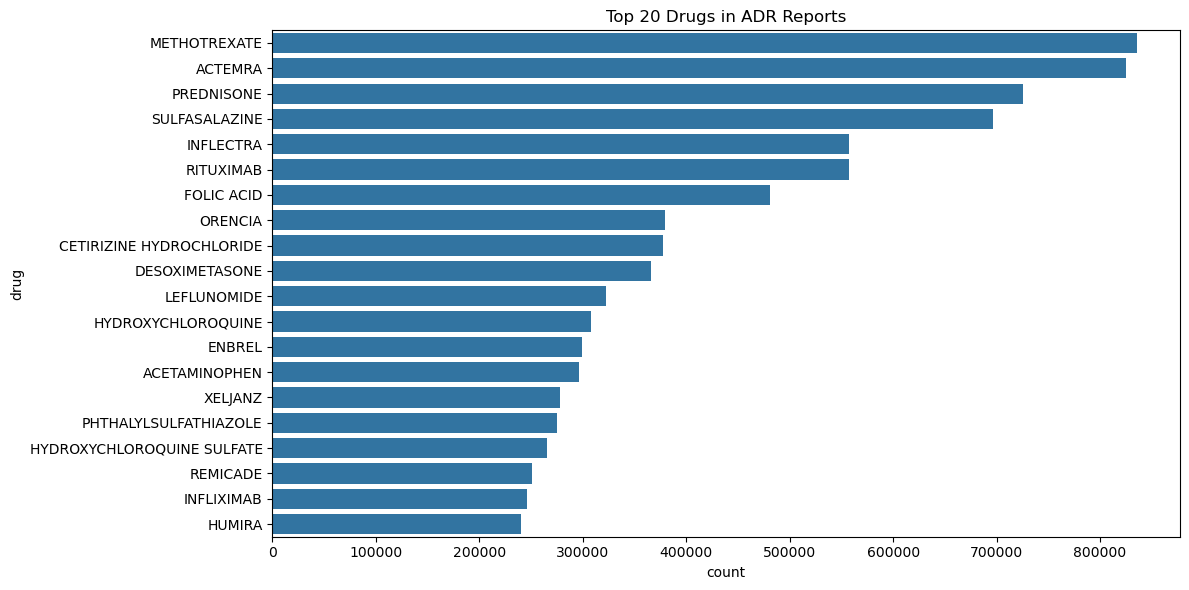

In [19]:
top_drugs = df.groupBy("drug").count().orderBy("count", ascending=False).limit(20).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_drugs, x="count", y="drug")
plt.title("Top 20 Drugs in ADR Reports")
plt.tight_layout()
plt.show()

#### Step 3: Drug vs Reaction Heatmap (Pivot Table)

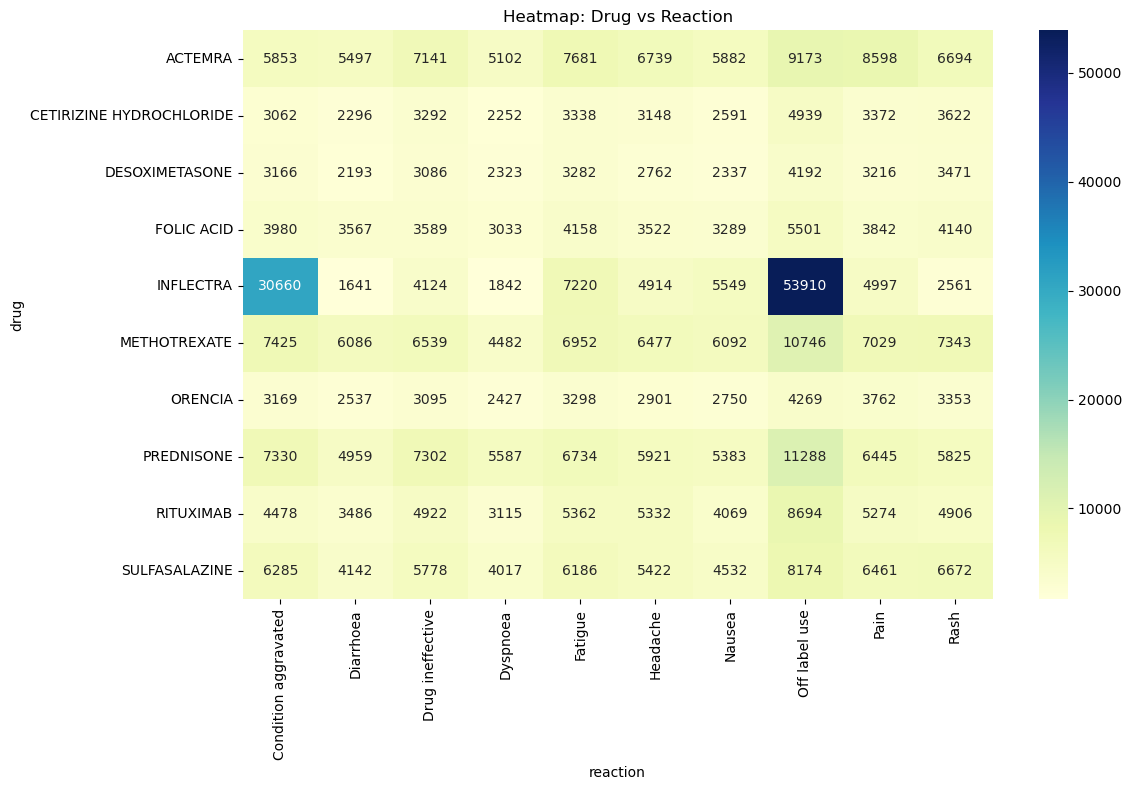

In [22]:
top_10_drugs = [row['drug'] for row in df.groupBy("drug").count().orderBy("count", ascending=False).limit(10).collect()]
top_10_reactions = [row['reaction'] for row in df.groupBy("reaction").count().orderBy("count", ascending=False).limit(10).collect()]

df_filtered = df.filter((col("drug").isin(top_10_drugs)) & (col("reaction").isin(top_10_reactions)))

pivot_df = df_filtered.groupBy("drug", "reaction").count().toPandas()
heatmap_data = pivot_df.pivot(index="drug", columns="reaction", values="count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="g", cmap="YlGnBu")
plt.title("Heatmap: Drug vs Reaction")
plt.tight_layout()
plt.show()

#### Step 4: Age Group vs Reaction Heatmap

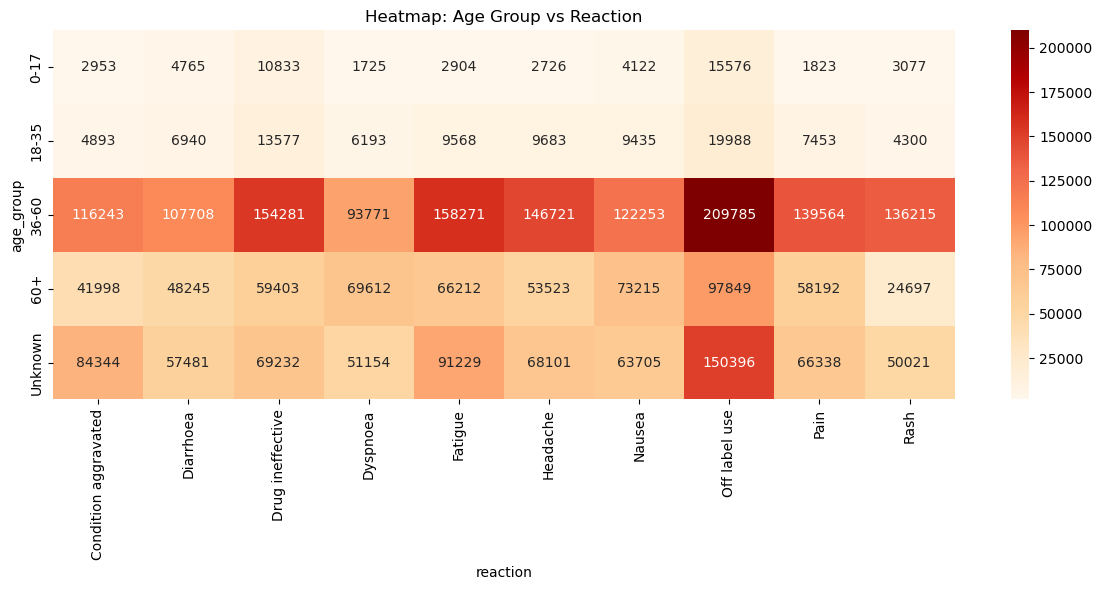

In [23]:
from pyspark.sql.functions import when

df_age = df.withColumn(
    "age_group",
    when(col("age") < 18, "0-17")
    .when((col("age") >= 18) & (col("age") <= 35), "18-35")
    .when((col("age") > 35) & (col("age") <= 60), "36-60")
    .when((col("age") > 60), "60+")
    .otherwise("Unknown")
)

df_age_filtered = df_age.filter(col("reaction").isin(top_10_reactions))
pivot_age = df_age_filtered.groupBy("age_group", "reaction").count().toPandas()
heatmap_age = pivot_age.pivot(index="age_group", columns="reaction", values="count").fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_age, annot=True, fmt="g", cmap="OrRd")
plt.title("Heatmap: Age Group vs Reaction")
plt.tight_layout()
plt.show()

#### Step 5: Reaction Frequency by Sex

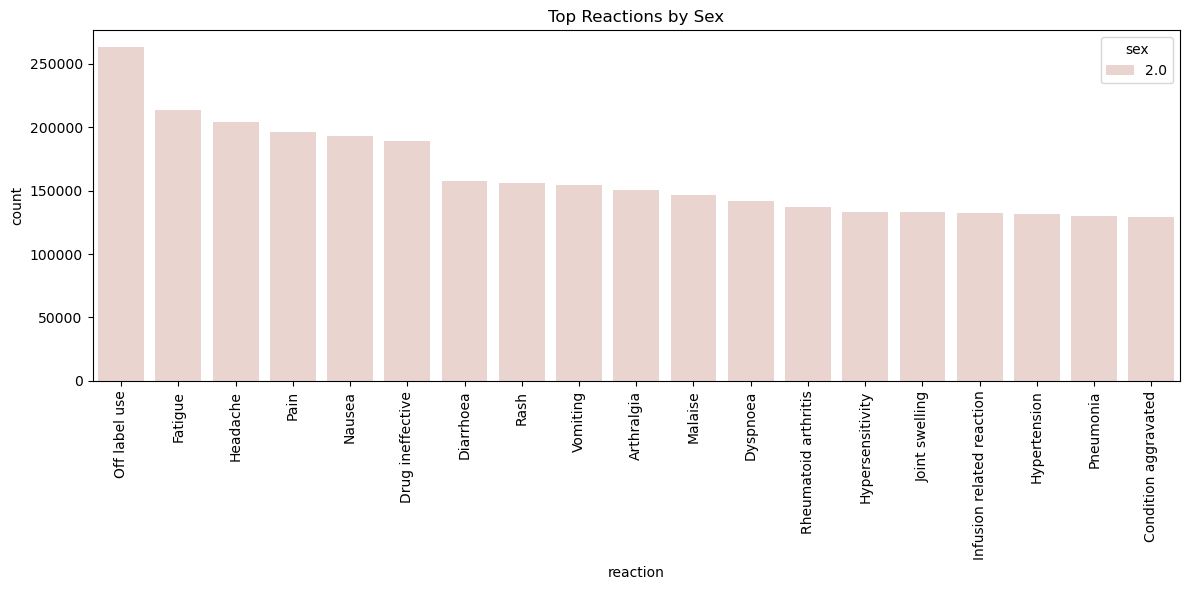

In [24]:
reaction_sex_df = df.groupBy("sex", "reaction").count().orderBy("count", ascending=False).limit(20).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=reaction_sex_df, x="reaction", y="count", hue="sex")
plt.xticks(rotation=90)
plt.title("Top Reactions by Sex")
plt.tight_layout()
plt.show()